In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.metrics import make_scorer
from time import perf_counter
from xgboost import XGBRegressor


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

In [2]:
%matplotlib inline
sns.set_theme()

## Loding Data

Load the full car datset. Keep only a subset of columns useful for prediction.
Drop the samples with key features missing (mileage, age, price, power).
Drop the samples with clear input errors or very rare features
Split the df in train and test. 

In [2]:
file_path = os.path.join("..", "data", "usedcars_dataset.parquet")
df_raw = pd.read_parquet(file_path)

In [3]:
final_col = ['Carburante',
                 'Carrozzeria',
                 'Chilometraggio',
                 'Cilindrata_cm3',
                 'Cilindri',
                 'Colore',
                 'Consumo_comb_L100km',
                 'Consumo_extraurb_L100km',
                 'Consumo_urb_L100km',
                 'Marce',
                 'Peso_a_vuoto_kg',
                 'Tagliandi_certificati',
                 'Tipo_di_cambio',
                 'Trazione',
                 'country',
                 'makeId',
                 'maker',
                 'model',
                 'modelOrModelLineId',
                 'potenza_kw',
                 'price',
                 'unico_proprietario',
                 'zip',
                 'age_years'
            ]

#    .drop(columns=[col for col in df_raw.columns if col not in final_col])
MAX_KM = 1e6
MAX_CV = 1000
MAX_AGE = 100
MAX_PRICE = 1e6
MIN_PRICE = 100
MAX_ENGSIZE = 1e4

In [4]:
df_clean = (df_raw.astype({'Anno':'datetime64[ns]', 'date':'datetime64[ns]'})
    .assign(age_years= lambda x: (x['date'] - x['Anno']) / np.timedelta64(1, 'Y'))
    .dropna(subset=['price', 'potenza_kw', 'age_years', 'Chilometraggio'])
    .query("~((age_years>@MAX_AGE or age_years < 0) \
                            or (potenza_cv > @MAX_CV or potenza_cv < 0) \
                            or (Chilometraggio>@MAX_KM or Chilometraggio < 0) \
                            or (price > @MAX_PRICE or price < @MIN_PRICE ) \
                            or (Cilindrata_cm3 > @MAX_ENGSIZE or Cilindrata_cm3 < 0 ) \
                )"
            )
)

In [5]:
df_train, df_test = train_test_split(df_clean, test_size=0.1)

## Loss Functions

In [6]:
def rmse_loss(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def rmspe_loss(y_true, y_pred):
    return np.mean((y_true-y_pred)**2/y_true**2)**0.5

def mape_loss(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))

rmse = make_scorer(rmse_loss, greater_is_better=False)
mae = make_scorer(mean_absolute_error, greater_is_better=False)
rmspe = make_scorer(rmspe_loss, greater_is_better=False)
mape = make_scorer(mape_loss, greater_is_better=False)

def show_losses(y_true, y_pred):
    d = {}
    d['rmse'] = [rmse_loss(y_true, y_pred)]
    d['rmspe'] = [rmspe_loss(y_true, y_pred)]
    d['mae'] = [mean_absolute_error(y_true, y_pred)]
    d['mape'] = [mape_loss(y_true, y_pred)]
    d['medae'] = [median_absolute_error(y_true, y_pred)]
    d['max_ae'] = [np.max(np.abs(y_true-y_pred))]
    d['max_pe'] = [np.max(np.abs(y_true-y_pred)/y_true)]
    
    df = pd.DataFrame(data=d)
    display(df)
    

## Baseline

Most simple baseline: using the mean/median as prediciton

In [7]:
price_mean = float(df_train['price'].mean())
price_median = float(df_train['price'].median())

In [8]:
print('Baseline Mean')
show_losses(df_test['price'].to_numpy(), np.ones(len(df_test))*price_mean)

print('Baseline Median')
show_losses(df_test['price'].to_numpy(), np.ones(len(df_test))*price_median)

Baseline Mean


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,21712.051324,2.056696,11282.311961,0.950889,8226.250559,777523.749441,41.952501


Baseline Median


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,22122.200152,1.615543,10716.622312,0.748252,7044.0,781544.0,33.912


## Manual exploration of models

In [10]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop(columns=['price']), 
                                                    df_train['price'], 
                                                    test_size=0.2, random_state=42
                                                   )

In [11]:
num_features = ['age_years', 'potenza_kw', 'Chilometraggio', 'Cilindrata_cm3']
cat_features = ['Tipo_di_cambio', 'Trazione', 'Carrozzeria', 'Carburante']

In [12]:
#Numerical features pipeline
num_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)


#Categorical features pipeline
cat_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

# Preprocessing pipeline
preprocessor = make_column_transformer(
    (num_transformer, num_features),
    (cat_transformer, cat_features),
    remainder='drop'
)

## Linear Models

In [13]:
# Full model pipeline
lm_model = make_pipeline(
    preprocessor,
    LinearRegression()    
)

In [14]:
lm_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age_years', 'potenza_kw',
                                                   'Chilometraggio',
                                                   'Cilindrata_cm3']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                

In [15]:
#Linear model predictions
y_train_lmp = lm_model.predict(X_train)
y_val_lmp = lm_model.predict(X_val)

In [16]:
print('Train Set')
show_losses(y_train, y_train_lmp)

print('Test Set')
show_losses(y_val, y_val_lmp)

Train Set


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,13096.137329,1.532985,5983.438545,0.434651,3713.0,859281.25,221.429167


Test Set


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,14127.27009,1.164603,6142.879467,0.443315,3753.125,661180.875,47.7215


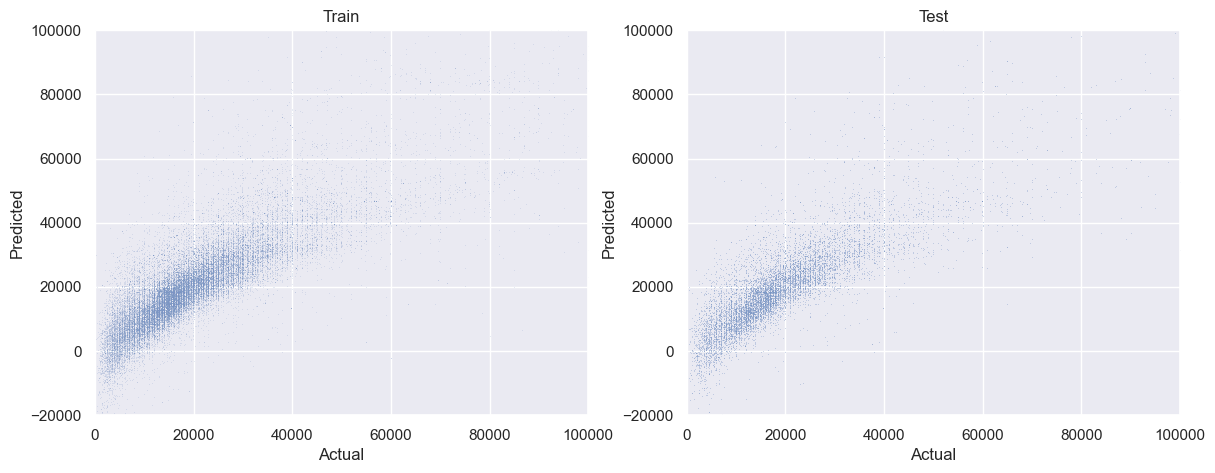

In [17]:
MAX_PRICE_PLOT = 1e5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
sns.scatterplot(x=y_train, y=y_train_lmp, s=0.1, ax=ax1)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set(xlim=[0, MAX_PRICE_PLOT], ylim=[-2e4, MAX_PRICE_PLOT], title='Train')
sns.scatterplot(x=y_val, y=y_val_lmp, s=0.2, ax=ax2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set(xlim=[0, MAX_PRICE_PLOT], ylim=[-2e4, MAX_PRICE_PLOT], title='Test');

## Random Forest Model

In [18]:
# Full model pipeline
rf_model = make_pipeline(
    preprocessor,
    RandomForestRegressor()    
)

In [19]:
rf_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age_years', 'potenza_kw',
                                                   'Chilometraggio',
                                                   'Cilindrata_cm3']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                

In [22]:
#Random forest predictions
y_train_rfp = rf_model.predict(X_train)
y_val_rfp = rf_model.predict(X_val)

In [23]:
print('Train Set')
show_losses(y_train, y_train_rfp)

print('Test Set')
show_losses(y_val, y_val_rfp)

Train Set


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,3441.941166,0.890074,917.466082,0.054562,366.18,228097.97,177.636656


Test Set


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,10872.026912,0.421969,2553.897514,0.139069,973.94,596262.23,22.56564


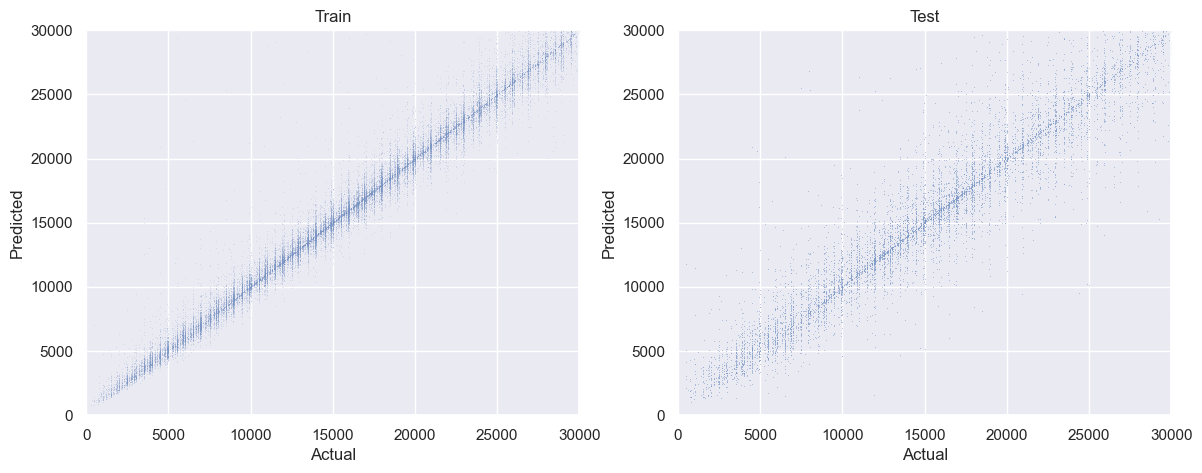

In [24]:
MAX_PRICE_PLOT = 0.3e5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
sns.scatterplot(x=y_train, y=y_train_rfp, s=0.1, ax=ax1)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set(xlim=[0, MAX_PRICE_PLOT], ylim=[0, MAX_PRICE_PLOT], title='Train')
sns.scatterplot(x=y_val, y=y_val_rfp, s=0.3, ax=ax2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set(xlim=[0, MAX_PRICE_PLOT], ylim=[0, MAX_PRICE_PLOT], title='Test');

## XGB Model

In [25]:
# Full model pipeline
xg_model = make_pipeline(
    preprocessor,
    XGBRegressor()    
)

In [26]:
xg_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age_years', 'potenza_kw',
                                                   'Chilometraggio',
                                                   'Cilindrata_cm3']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                

In [27]:
#XGB predictions
y_train_xgp = xg_model.predict(X_train)
y_val_xgp = xg_model.predict(X_val)

In [28]:
print('Train Set')
show_losses(y_train, y_train_xgp)

print('Test Set')
show_losses(y_val, y_val_xgp)

Train Set


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,3517.92102,0.482947,2261.155268,0.142799,1517.238281,141803.359375,78.249062


Test Set


,rmse,rmspe,mae,mape,medae,max_ae,max_pe
0,10521.77111,0.40573,2989.227676,0.165671,1584.044922,665373.390625,18.557287


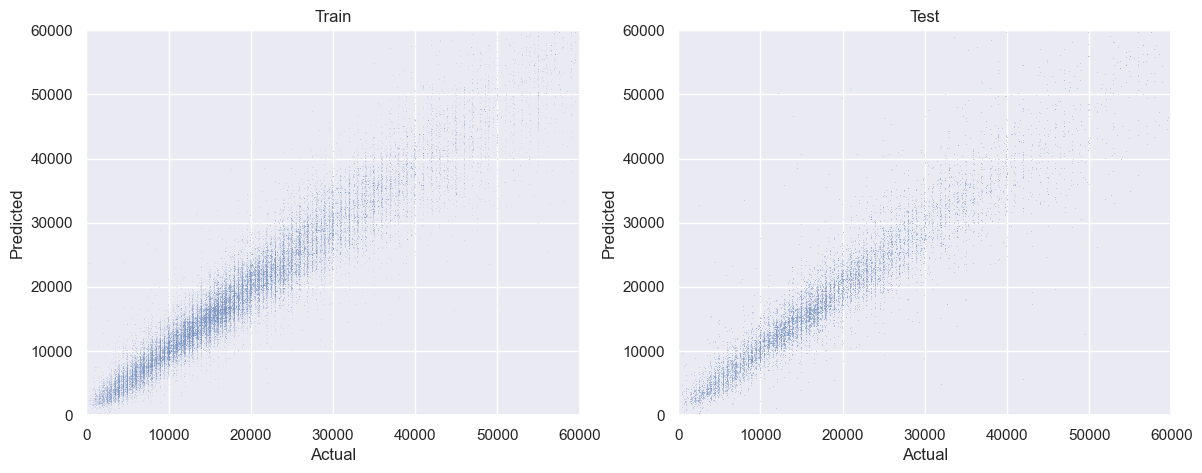

In [30]:
MAX_PRICE_PLOT = 0.6e5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
sns.scatterplot(x=y_train, y=y_train_xgp, s=0.1, ax=ax1)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set(xlim=[0, MAX_PRICE_PLOT], ylim=[0, MAX_PRICE_PLOT], title='Train')
sns.scatterplot(x=y_val, y=y_val_xgp, s=0.2, ax=ax2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set(xlim=[0, MAX_PRICE_PLOT], ylim=[0, MAX_PRICE_PLOT], title='Test');